In [1]:
import glob
import os
import math
import librosa
import numpy as np
from scipy.signal import resample as sci_resample
import mne
from mtrf.model import TRF
from eelbrain import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import itertools
from scipy import stats

sns.set_theme(
                style='white', 
                palette='Set1',
                rc={'figure.dpi': 150}
            )

g:\Utilisateurs\rudradeep.guha\AppData\Local\miniforge3\envs\looming\Lib\site-packages\eelbrain\mne_fixes\_interpolation.py:13: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
  from mne.io.pick import pick_types, pick_channels
g:\Utilisateurs\rudradeep.guha\AppData\Local\miniforge3\envs\looming\Lib\site-packages\eelbrain\mne_fixes\_interpolation.py:13: FutureWarning: mne.io.pick.pick_channels is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
  from mne.io.pick import pick_types, pick_channels
G:\Utilisateurs\rudradeep.guha\AppData\Local\Temp\ipykernel_5368\683897316.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and

# Variables

In [2]:
# info is a dictionary containing information about each kind of stimulus that is used very often throughout the analysis.

# marker_code: the code used to identify epochs of this particular stimulus in the EEG data,
# color: the color used for this stimulus in all plots throughout the analysis,
# is_deviant: whether the stimulus is a deviant or a standard,
# audio_file: path to audio file of the stimulus (to get RMS response),
# an_file: path to csv file containing auditory nerve response data

info = {
        'standard': {
                        'marker_code': '1001', 
                        'color': 'k', 
                        'is_deviant': False,
                        'length': 0.300,
                        'audio_file': './sounds/standard_1000Hz_300ms_15dB_sigmoid_0_flat_0ms_slope_7.wav', 
                        'an_file': './an_responses/AN_standard.csv'
                    }, 
        'looming':  {
                        'marker_code': '1002', 
                        'color': 'r',
                        'is_deviant': True, 
                        'length': 0.600,
                        'audio_file': './sounds/deviant_looming_1000Hz_600ms_15dB_sigmoid_0_flat_0ms_slope_7.wav',
                        'an_file': './an_responses/AN_looming.csv'
                    }, 
        'receding': {
                        'marker_code': '1003', 
                        'color': 'g', 
                        'is_deviant': True, 
                        'length': 0.600,
                        'audio_file': './sounds/deviant_receding_1000Hz_600ms_15dB_sigmoid_0_flat_0ms_slope_7.wav', 
                        'an_file': './an_responses/AN_receding.csv'
                    }, 
        'flat':     {
                        'marker_code': '1004', 
                        'color': 'b', 
                        'is_deviant': True,
                        'length': 0.600,
                        'audio_file': './sounds/deviant_flat_1000Hz_600ms_15dB_sigmoid_0_flat_0ms_slope_7.wav',
                        'an_file': './an_responses/AN_flat.csv'
                    }
        }

conditions = ['actual', 'predicted'] 
sr = 128                                    # sampling rate of input and output
trial_length = 0.7
num_samples = math.ceil(sr*trial_length)
subj_dir = './analysis_800ms_epochs/'       # path to EEG files
model_input = 'auditory_nerve'              # can be either 'rms' or 'auditory_nerve'
trf_direction = 1                           # 1 for forward model, -1 for backward model
trf_min_lag = 0
trf_max_lag = 0.7
num_subjs = len(glob.glob(subj_dir+'looming*-epo.fif'))

# Data store

In [3]:
# list of headers for the DataFrame we would like to have at the end of the analysis
headers = [
            'subject', 'stimulus', 'response', 
            'looming_evoked', 'receding_evoked', 'flat_evoked', 
            'trf', 'trf_weight',
            'looming_prediction', 'receding_prediction', 'flat_prediction', 
            'looming_correlation', 'receding_correlation', 'flat_correlation'
        ]   
# a dictionary behaving like a central data storage in which we store all the data as we go along with the analysis
data_store = dict((k, np.zeros(num_subjs, dtype=object)) for k in headers)  

# Helper functions

In [4]:
# convenience function to get values from the info dict
def get_info_key(search_key, search_val):
    for k, v in info.items():
        for k1, v1 in info.get(k).items():
            if (k1==search_key) and (v1==search_val):
                return k

# Load subject files

In [5]:
# create dictionary of subjects with option to exclude some (provide id as string in the exclude arg)
def get_subjects(exclude=[]):
    subjs = [el.lower().replace(os.sep, '/') for el in glob.glob(subj_dir+'looming*-epo.fif')]
    subjs = sorted(subjs, key=lambda x: int(x.split('-')[0][-3:]))
    subj_dict = dict(zip([int(el.split('-')[0][-2:]) for el in subjs], subjs))
    if exclude:
        for id in exclude:
            subj_dict.pop(id, None)

    return subj_dict

subjects = get_subjects()
subjects

{2: './analysis_800ms_epochs/looming002-epo.fif',
 3: './analysis_800ms_epochs/looming003-epo.fif',
 4: './analysis_800ms_epochs/looming004-epo.fif',
 5: './analysis_800ms_epochs/looming005-epo.fif',
 6: './analysis_800ms_epochs/looming006-epo.fif',
 8: './analysis_800ms_epochs/looming008-epo.fif',
 9: './analysis_800ms_epochs/looming009-epo.fif',
 10: './analysis_800ms_epochs/looming0010-epo.fif',
 11: './analysis_800ms_epochs/looming0011-epo.fif',
 12: './analysis_800ms_epochs/looming0012-epo.fif',
 14: './analysis_800ms_epochs/looming0014-epo.fif',
 15: './analysis_800ms_epochs/looming0015-epo.fif',
 16: './analysis_800ms_epochs/looming0016-epo.fif',
 17: './analysis_800ms_epochs/looming0017-epo.fif',
 18: './analysis_800ms_epochs/looming0018-epo.fif'}

# Prepare data

In [6]:
def get_data(type, file):
    file = file.replace(os.sep, '/')

    match type:
        case 'rms':
            audio_data, audio_sr = librosa.load(file)
            rms_win = 0.01                                  # 10 ms
            rms_hop = 1/sr                                  # hop by eeg sampling rate
            rms = librosa.feature.rms(y=audio_data, frame_length=int(audio_sr*rms_win), hop_length=int(audio_sr*rms_hop))
            data=rms[0]
            # get which deviant it is (flat/looming/receding) from the filename in arg
            deviant = get_info_key('audio_file', file)
        case 'auditory_nerve':
            df = pd.read_csv(file, usecols=[1])
            data = df.to_numpy().flatten()
            deviant = get_info_key('an_file', file)
        case _:
            raise ValueError(f"{type} not a valid value for type. Valid values are: ['rms', 'auditory_nerve']")

    # resample   
    data_resampled = sci_resample(data, len(np.arange(0, info.get(deviant)['length'], 1/sr)))
    # DO NOT pad before
    pad_before = math.ceil((0-trf_min_lag)*sr)
    # Need to pad after because epochs are longer than the stimuli and they need to have the same length
    pad_after = math.ceil(num_samples - (len(data_resampled)+pad_before))
    data_resampled_padded = np.pad(data_resampled, pad_width=(pad_before, pad_after))
    
    return data_resampled_padded

In [7]:
def prepare_epochs(file):
    file = file.replace(os.sep, '/')
    epochs = mne.read_epochs(file, preload=True, verbose=False)
    epochs = epochs.drop_channels('STI')
    epochs_resampled = epochs.resample(sr)
    # crop epochs so that they range from 0 to 700ms
    shorter_epochs = epochs_resampled.copy().crop(tmin=trf_min_lag, tmax=trf_max_lag, include_tmax=True)

    return shorter_epochs

In [8]:
def get_evokeds(epochs):
    # average all standard epochs so that this average epoch can be subtracted from each epoch to get difference waves
    standard_avg = epochs['1001'].average()

    evokeds = []
    for k, v in info.items():
        if info.get(k)['is_deviant']:
            # average all epochs for this particular deviant
            deviant_avg = epochs[info.get(k)['marker_code']].average()
            # subtract standard from deviant
            deviant_std_evk = mne.combine_evoked([deviant_avg, standard_avg], weights=[1, -1])
            evokeds.append(deviant_std_evk)
            
    return evokeds

In [9]:
def make_stim():
    if model_input == 'rms':
        key = 'audio_file'
    elif model_input == 'auditory_nerve':
        key = 'an_file'

    flat = get_data(type=model_input, file=info.get('flat')[key])
    standard = get_data(type=model_input, file=info.get('standard')[key])
    stim = flat-standard
    stim = np.reshape(stim, (-1, 1))
    
    return stim


def make_resp(epochs, idx):
    eeg_deviant = epochs.get_data(item=idx)[0]
    eeg_std = epochs.get_data(item=idx-1)[0]
    # for each deviant epoch, subtract the preceding standard epoch from it to get difference waves
    diff_wave = (eeg_deviant - eeg_std).T
    
    return diff_wave

In [10]:
print('Preparing correctly formatted data for input to the TRF...')

for i, (subject_id, subject_file) in enumerate(tqdm(subjects.items())):
    epochs = prepare_epochs(subject_file)
    evokeds = get_evokeds(epochs)

    stims, resps = [], []
    for j in range(len(epochs)):
        if epochs[j].events[:, 2][0] == 1004:   # only train on Flat deviants
            stim = make_stim()
            resp = make_resp(epochs, j)
            stims.append(stim)
            resps.append(resp)

    # for each subject, store data required to train the TRFs in data_store
    data_store['subject'][i] = subject_id
    data_store['looming_evoked'][i] = evokeds[0]
    data_store['receding_evoked'][i] = evokeds[1]
    data_store['flat_evoked'][i] = evokeds[2]
    data_store['stimulus'][i] = stims
    data_store['response'][i] = resps

Preparing correctly formatted data for input to the TRF...


  0%|          | 0/15 [00:00<?, ?it/s]G:\Utilisateurs\rudradeep.guha\AppData\Local\Temp\ipykernel_5368\23264570.py:7: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.696875 s)
  shorter_epochs = epochs_resampled.copy().crop(tmin=trf_min_lag, tmax=trf_max_lag, include_tmax=True)
  7%|▋         | 1/15 [00:08<02:01,  8.69s/it]G:\Utilisateurs\rudradeep.guha\AppData\Local\Temp\ipykernel_5368\23264570.py:7: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.696875 s)
  shorter_epochs = epochs_resampled.copy().crop(tmin=trf_min_lag, tmax=trf_max_lag, include_tmax=True)
 13%|█▎        | 2/15 [00:28<03:18, 15.26s/it]G:\Utilisateurs\rudradeep.guha\AppData\Local\Temp\ipykernel_5368\23264570.py:7: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.696875 s)
  shorter_epochs = epochs_resampled.copy().crop(tmin=trf_min_lag, tmax=trf_max_lag, include_tm

# Train TRF

In [11]:
def plot_vals(
        trf,
        channel=None,
        feature=None,
        axes=None,
        show=True,
        kind="line",
    ):
        """
        Plot the weights of the (forward) model across time for a select channel or feature.

        Arguments:
            channel (None | int | str): Channel selection. If None, all channels will be used. If an integer, the channel at that index will be used. If 'avg' or 'gfp' , the average or standard deviation across channels will be computed.
            feature (None | int | str): Feature selection. If None, all features will be used. If an integer, the feature at that index will be used. If 'avg' , the average across features will be computed.
            axes (matplotlib.axes.Axes): Axis to plot to. If None is provided (default) generate a new plot.
            show (bool): If True (default), show the plot after drawing.
            kind (str): Type of plot to draw. If 'line' (default), average the weights across all stimulus features, if 'image' draw a features-by-times plot where the weights are color-coded.
        """

        weights = trf.weights
        # select channel and or feature
        if weights.shape[0] == 1:
            feature = 0
        if weights.shape[-1] == 1:
            channel = 0
        if channel is None and feature is None:
            raise ValueError("You must specify a subset of channels or features!")
        if feature is not None:
            image_ylabel = "channel"
            if isinstance(feature, int):
                weights = weights[feature, :, :]
            elif feature == "avg":
                weights = weights.mean(axis=0)
            else:
                raise ValueError('Argument `feature` must be an integer or "avg"!')
        if channel is not None:
            image_ylabel = "feature"
            if isinstance(channel, int):
                weights = weights.T[channel].T
            elif channel == "avg":
                weights = weights.mean(axis=-1)
            elif channel == "gfp":
                weights = weights.std(axis=-1)
            else:
                raise ValueError(
                    'Argument `channel` must be an integer, "avg" or "gfp"'
                )
            weights = weights.T  # transpose so first dimension is time
            
            return weights

In [12]:
print('Training the TRF...')

for i, (subject_id, subject_file) in enumerate(tqdm(subjects.items())):     # train a separate TRF for each subject
    trf = TRF(direction=trf_direction)

    inp = data_store['stimulus'][i]
    out = data_store['response'][i]

    # r_unbiased, best_regularization = nested_crossval(trf, data_store['stimulus'][i], data_store['response'][i], sr, tmin=trf_min_lag, tmax=trf_max_lag, regularization=regularization, k=5)
    # give the function all trials at once. 
    # It computes a separate covariance matrix for each trial and then concatenates the matrices to get the weights for a single TRF.
    trf.train(inp, out, sr, tmin=trf_min_lag, tmax=trf_max_lag, regularization=1000)

    # store the TRF object
    data_store['trf'][i] = trf
    # store the TRF weights (only for plotting the TRF later)
    # channel=2 because it is the ID for Fz
    data_store['trf_weight'][i] = plot_vals(trf, channel=2)

Training the TRF...


100%|██████████| 15/15 [00:00<00:00, 38.27it/s]


# Plot stimuli & TRF

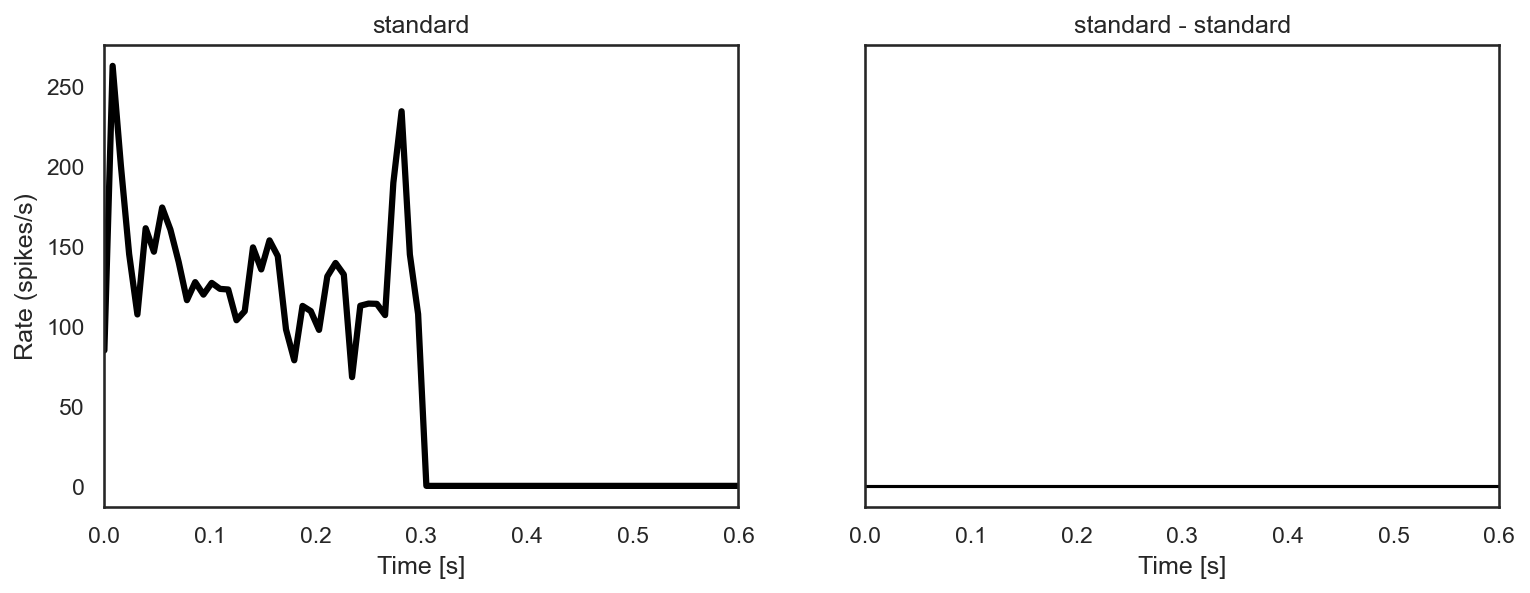

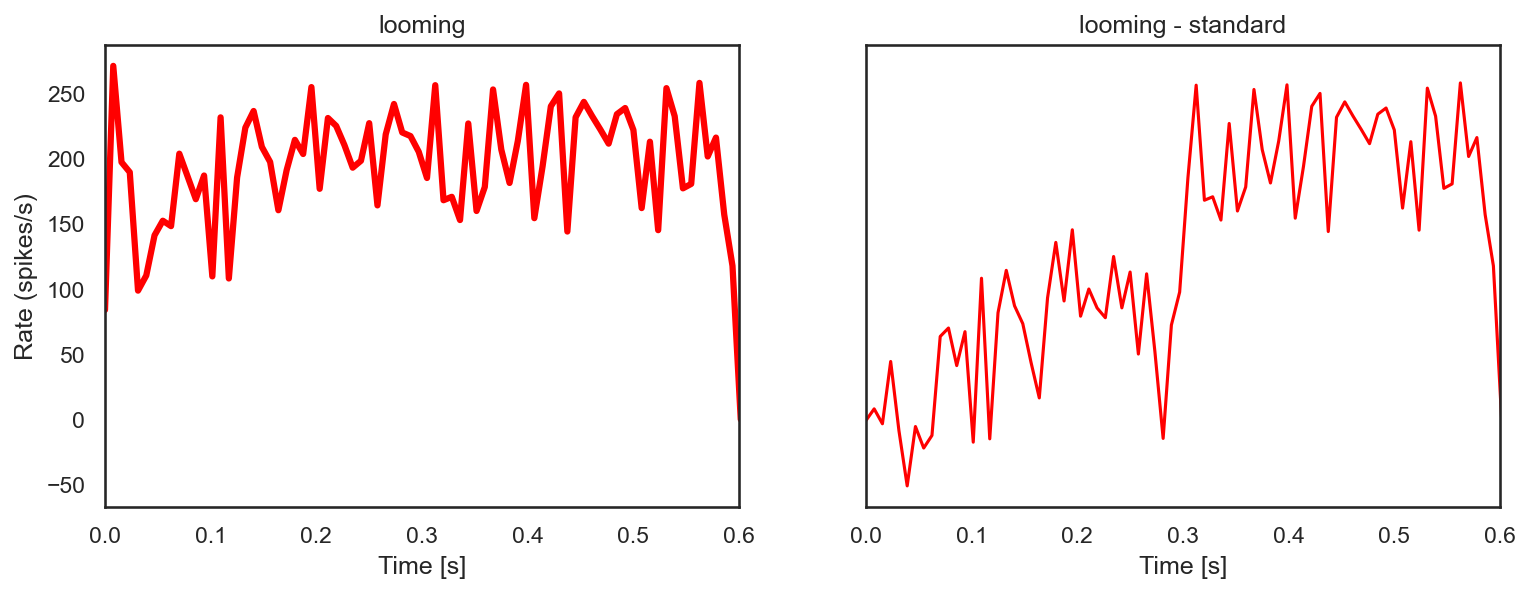

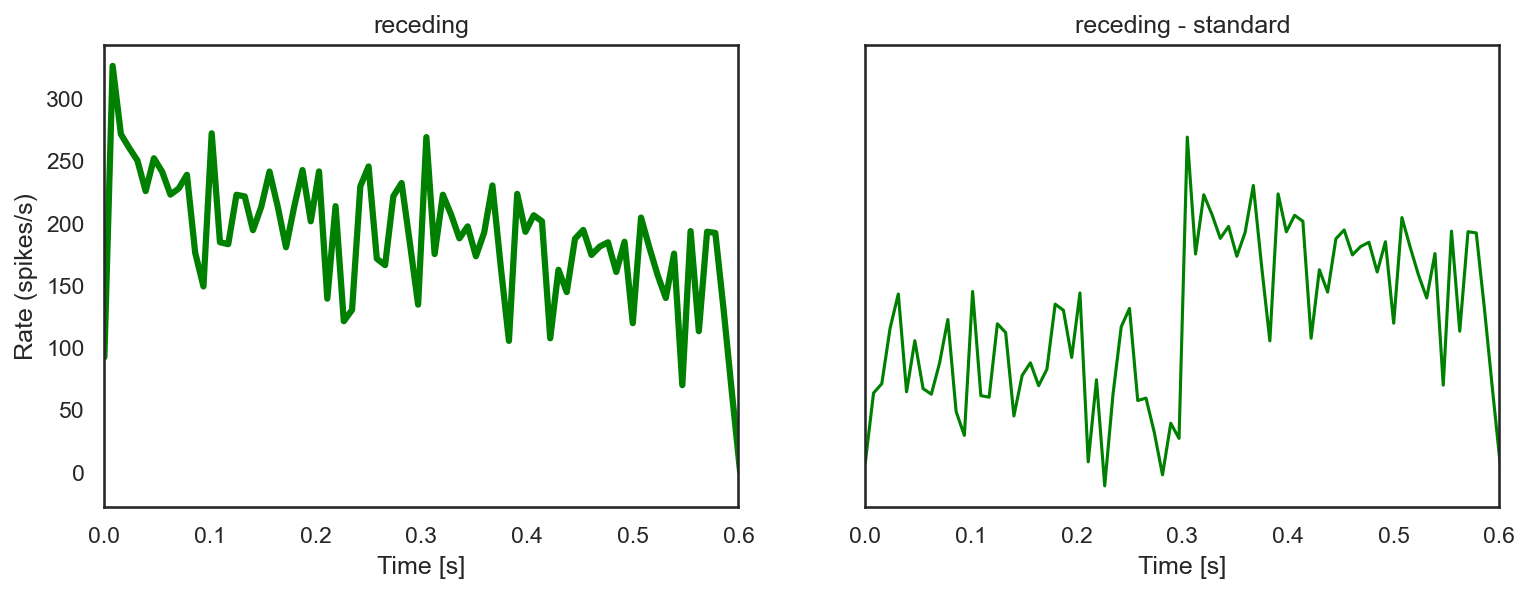

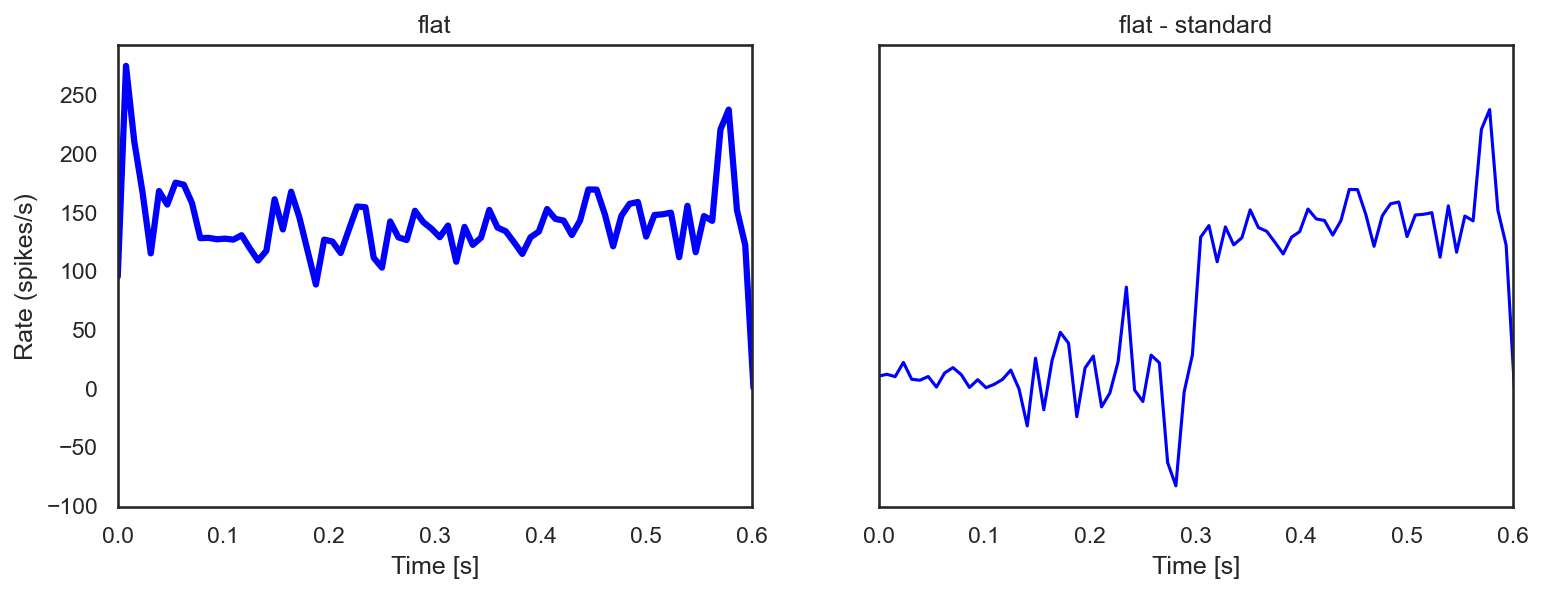

In [13]:
for i, (k, v) in enumerate(info.items()):
    if model_input == 'rms':
        key = 'audio_file'
    elif model_input == 'auditory_nerve':
        key = 'an_file'

    data = get_data(type=model_input, file=v[key])
    diff_data = data - get_data(type=model_input, file=info.get('standard')[key])

    fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12, 4))
    sns.lineplot(x=np.arange(trf_min_lag, trf_max_lag, 1/sr), y=data, color=v['color'], linewidth=3, ax=axs[0])
    axs[0].set_xlabel('Time [s]')
    axs[0].set_ylabel('Rate (spikes/s)')
    axs[0].set_xlim(0, 0.6)
    axs[0].set_title(k)

    sns.lineplot(x=np.arange(trf_min_lag, trf_max_lag, 1/sr), y=diff_data, color=v['color'], ax=axs[1])
    axs[1].set_xlim(0, 0.6)
    axs[1].set_title(f'{k} - standard')
    axs[1].set_xlabel('Time [s]')
    axs[1].set_ylabel('Rate (spikes/s)')

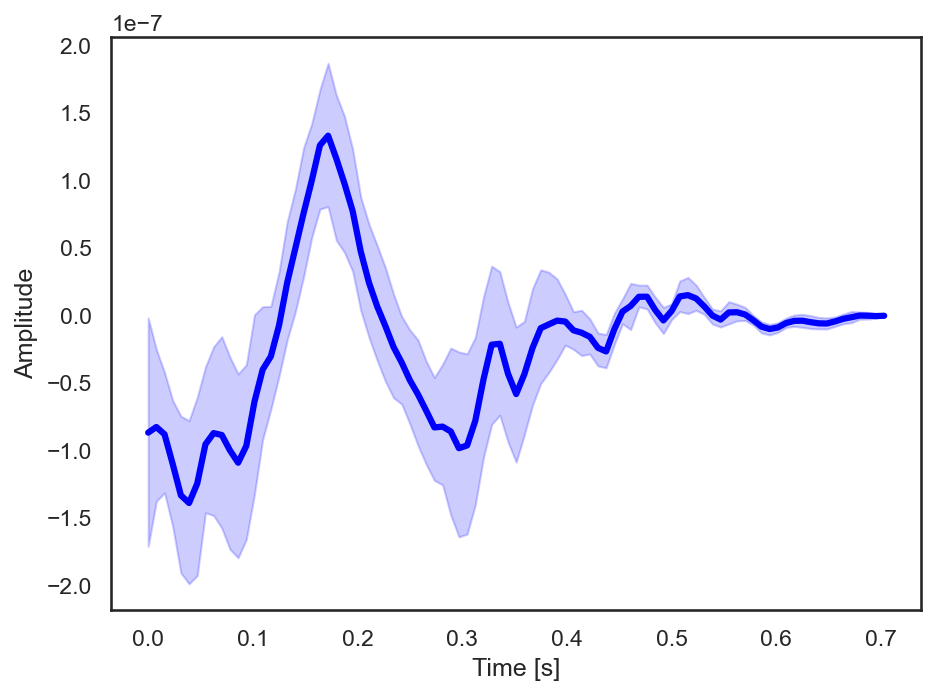

In [14]:
df_trf = pd.DataFrame({
    'trf': np.asarray([x.flatten() for x in data_store['trf_weight']]).flatten()
})
df_trf['time'] = np.tile(np.arange(trf_min_lag, 0.71, 1/sr), 15)
sns.lineplot(data=df_trf, x='time', y='trf', color='b', linewidth=3)
plt.tight_layout()
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
# plt.title('TRF over all participants')
plt.show();

# Predict responses

In [15]:
print('Predicting responses using trained TRF...')

for i, (subject_id, subject_file) in enumerate(tqdm(subjects.items())):     # predict response to each deviant using trained TRF of that particular subject
    for k, v in info.items():
        if info.get(k)['is_deviant'] == True:
            # if model_input == 'rms':
            #     deviant_stim = get_rms(info.get(k)['audio_file'])
            #     standard_stim = get_rms(info.get('standard')['audio_file'])
            # elif model_input == 'auditory_nerve':
            #     deviant_stim = get_an_response(info.get(k)['an_file'])
        #     standard_stim = get_an_response(info.get('standard')['an_file'])
            if model_input == 'rms':
                key = 'audio_file'
            elif model_input == 'auditory_nerve':
                key = 'an_file'

            deviant_stim = get_data(type=model_input, file=info.get(k)[key])
            standard_stim = get_data(type=model_input, file=info.get('standard')[key])
            stim = np.reshape(deviant_stim - standard_stim, (-1, 1))
            # stim = np.reshape(deviant_stim, (-1, 1))
            # use the average difference wave over all trials of this participant as actual response
            resp = data_store[f'{k}_evoked'][i]

            # predict response for all EEG channels
            prediction, correlation = data_store['trf'][i].predict(stim, resp.data.T)

            # store predicted time series
            data_store[f'{k}_prediction'][i] = prediction
            # store correlation between actual Fz response and predicted Fz response
            data_store[f'{k}_correlation'][i] = stats.pearsonr(resp.data[2], np.asarray(prediction)[0].T[2]).statistic


Predicting responses using trained TRF...


100%|██████████| 15/15 [00:00<00:00, 44.62it/s]


In [16]:
df = pd.DataFrame(data=data_store)

# Statistics

## Create Eelbrain dataset

In [17]:
rows = []

tstep = 1. / 128
n_times = num_samples
time = UTS(0, tstep, n_times)
sensor = Sensor.from_montage('easycap-M1')[:64]

# get list of deviants
deviants = [k for k in info.keys() if info.get(k)['is_deviant']]

for i in range(len(df)):
    for el in list(itertools.product(conditions, deviants)):
        id = df.iloc[i]['subject']
        condition = el[0]
        deviant = el[1]
        
        if condition == 'actual':
            fz_data = NDVar(df.iloc[i][f'{deviant}_evoked'].data.T[:, 1].flatten(), (time,))
        else:
            fz_data = NDVar(df.iloc[i][f'{deviant}_prediction'][0][:, 1], (time,))
        corr = df.iloc[i][f'{deviant}_correlation']

        rows.append([id, condition, deviant, fz_data, corr])
    
ds = Dataset.from_caselist(['id','condition', 'deviant', 'fz_data', 'corr'], rows)
ds['id'].random = True
print(ds.summary())

Key         Type     Values                             
--------------------------------------------------------
id          Var      2 - 18                             
condition   Factor   actual:45, predicted:45            
deviant     Factor   flat:30, looming:30, receding:30   
fz_data     NDVar    90 time; -9.68422e-06 - 3.48167e-06
corr        Var      -0.463993 - 0.965986               
--------------------------------------------------------
Dataset: 90 cases


## Plot actual and predicted difference waves

Key         Type     Values                             
--------------------------------------------------------
id          Var      2 - 18                             
condition   Factor   actual:45                          
deviant     Factor   flat:15, looming:15, receding:15   
fz_data     NDVar    90 time; -6.90058e-06 - 3.48167e-06
corr        Var      -0.463993 - 0.965986               
--------------------------------------------------------
Dataset: 45 cases
Key         Type     Values                             
--------------------------------------------------------
id          Var      2 - 18                             
condition   Factor   predicted:45                       
deviant     Factor   flat:15, looming:15, receding:15   
fz_data     NDVar    90 time; -9.68422e-06 - 2.08757e-06
corr        Var      -0.463993 - 0.965986               
--------------------------------------------------------
Dataset: 45 cases


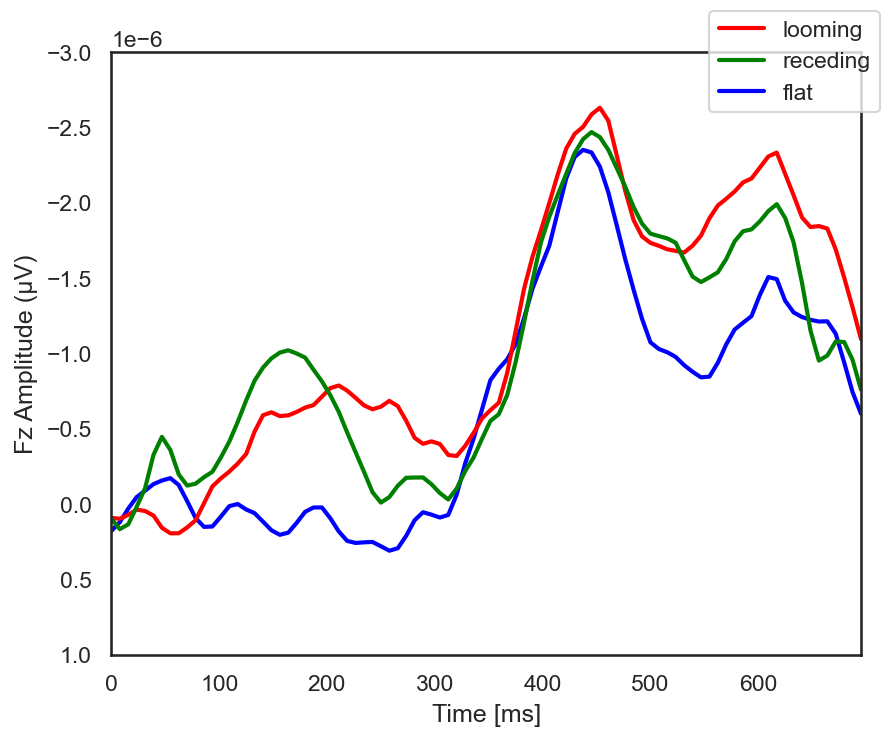

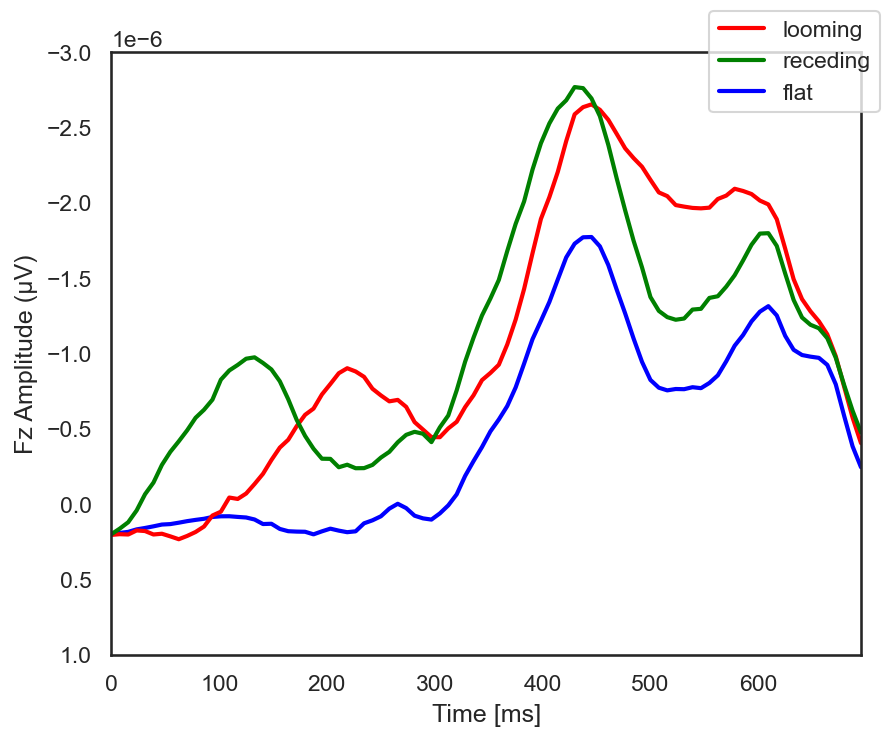

In [18]:
colors = dict((k, plot.Style(info.get(k)['color'], linewidth=2)) for k in info.keys() if info.get(k)['is_deviant'])


for cond in conditions:
    ds_cond = ds[ds['condition']==cond]
    print(ds_cond.summary())

    p = plot.UTSStat('fz_data', 'deviant', match='id', ds=ds_cond, title=None, w=6, h=5, error='none', colors=colors)
    p.set_ylabel('Fz Amplitude (µV)')
    p.set_ylim([1e-6, -3e-6])

## Temporal cluster permutation test

id   tstart   tstop   duration   v   p   sig
--------------------------------------------
id   tstart   tstop   duration   v   p   sig
--------------------------------------------
id   tstart   tstop   duration   v   p   sig
--------------------------------------------


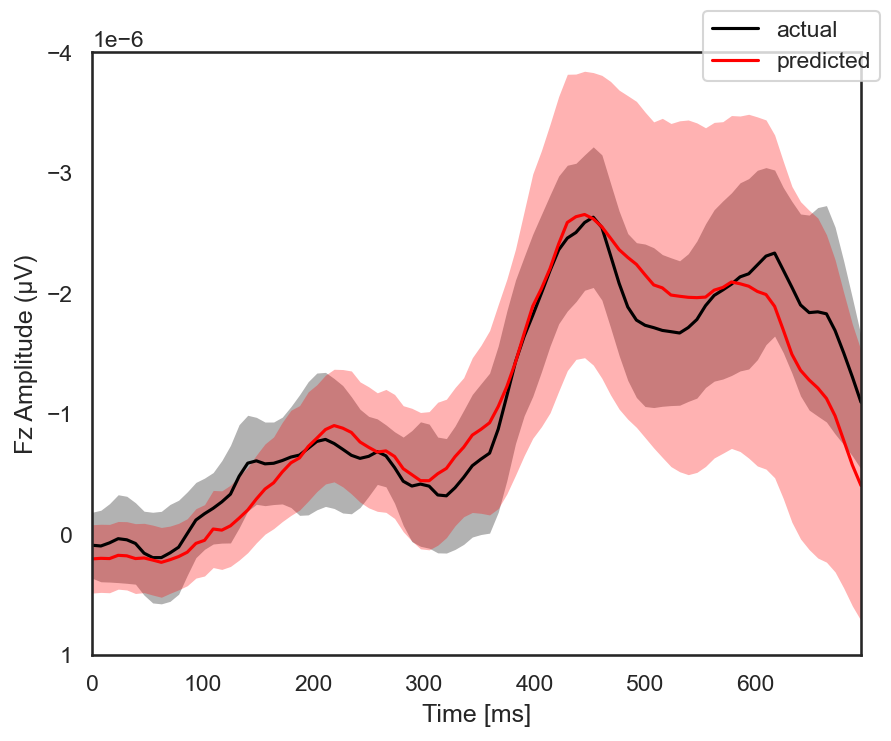

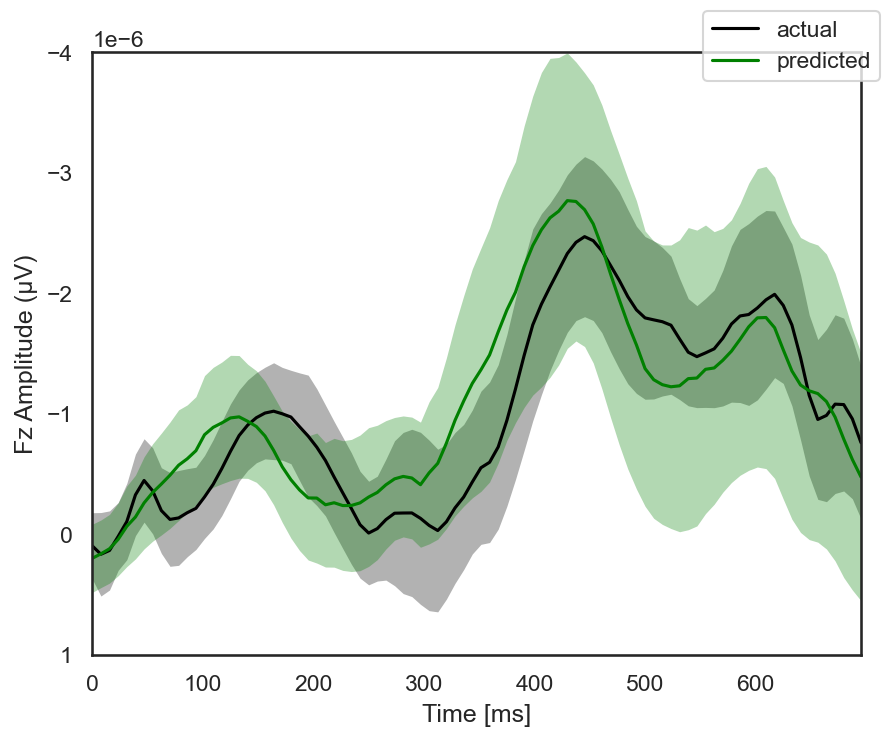

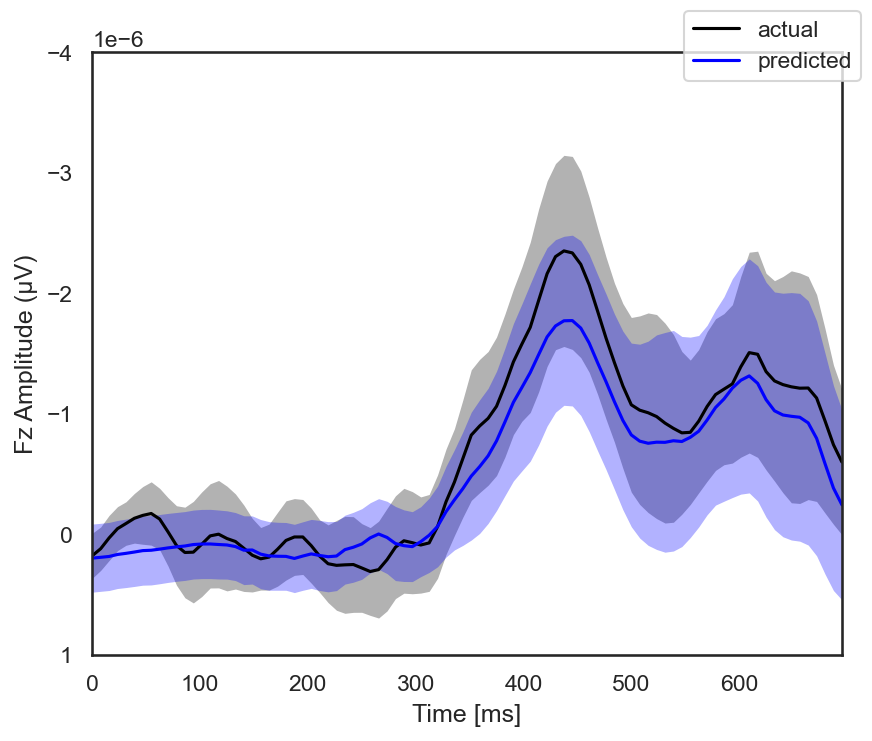

In [19]:
for deviant in deviants:
    ds_dev = ds[ds['deviant']==deviant]
    res_timecoure = testnd.TTestRelated(
        'fz_data', 'condition', 'actual', 'predicted', match='id', ds=ds_dev,
        pmin=0.05,
        tstart=trf_min_lag,
        tstop=trf_max_lag,
        mintime=0.2,
    )
    clusters_fz = res_timecoure.find_clusters(0.05)
    print(clusters_fz)

    p = plot.UTSStat('fz_data', 'condition', match='id', ds=ds_dev, title=None, w=6, h=5, error='ci', colors={'actual': 'k', 'predicted': info.get(deviant)['color']})
    p.set_clusters(clusters_fz)
    p.set_ylabel('Fz Amplitude (µV)')
    p.set_ylim([1e-6, -4e-6])